This notebook is meant to clean up the hist_payoff_loss_jan07_may13 dataset by adding rows for all ARMs and all fixed-rate loans, as well as rows for all Group I loans and all Group II loans.

The fixed_arm_totals and groups_I_II_totals functions are copied over from when I wrote up extract_mortgage_losses.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
hist_PL_BEFORE = pd.read_pickle('../../data/mbs_data_pickled/hist_payoff_loss_jan07_may13.pkl')

In [3]:
# Creates rows with totals for Fixed and ARM loans
def fixed_arm_totals(df, month):
    # For this particular month, set up rows to contain the total fixed and ARM data
    df.loc[(month,'Fixed'),:] = np.zeros((12))
    df.loc[(month,'ARM'),:] = np.zeros((12))
    fixed_only = df[df.index.get_level_values(1).str.contains('Fixed')]
    arm_only = df[df.index.get_level_values(1).str.contains('ARM')]
    
    # Calculate weighted averages for Remaining Term, Current WAC and Current WAC - Remit
    for col in df.columns.tolist()[-3:]:
        # For each column of data, find the weighted averages for fixed and adjustable rate loans
        fixed_weighted = fixed_only[fixed_only.index.get_level_values(0)==month][col] * \
            fixed_only[fixed_only.index.get_level_values(0)==month]['Ending Pool (Balance)']
        arm_weighted = arm_only[arm_only.index.get_level_values(0)==month][col] * \
            arm_only[arm_only.index.get_level_values(0)==month]['Ending Pool (Balance)']
        fixed_avg = fixed_weighted.sum() / \
            fixed_only[fixed_only.index.get_level_values(0)==month]['Ending Pool (Balance)'].sum()
        arm_avg = arm_weighted.sum() / \
            arm_only[arm_only.index.get_level_values(0)==month]['Ending Pool (Balance)'].sum()
        # Assign the weighted average to the general 'Fixed' and 'ARM' rows
        df.loc[(month,'Fixed'),col] = fixed_avg
        df.loc[(month,'ARM'),col] = arm_avg
    
    # Calculate sums for Ending Pool (Count) up through Realized Losses (Amount)
    for col in df.columns.tolist()[:-3]:
        df.loc[(month, 'Fixed'),col] = fixed_only[fixed_only.index.get_level_values(0)==month][col].sum()
        df.loc[(month, 'ARM'),col] = arm_only[arm_only.index.get_level_values(0)==month][col].sum()

In [4]:
# Creates rows with totals for Groups I and II
def groups_I_II_totals(df, month):
    # For this particular month, set up rows to contain the total Groups I and II data
    df.loc[(month,'Group I'),:] = np.zeros((12))
    df.loc[(month,'Group II'),:] = np.zeros((12))
    groupI_only = df[df.index.get_level_values(1).str.contains('Group I ')]
    groupII_only = df[df.index.get_level_values(1).str.contains('Group II')]
    
    # Calculate weighted averages for Remaining Term, Current WAC and Current WAC - Remit
    for col in df.columns.tolist()[-3:]:
        # For each column of data, find the weighted averages for fixed and adjustable rate loans
        groupI_weighted = groupI_only[groupI_only.index.get_level_values(0)==month][col] * \
            groupI_only[groupI_only.index.get_level_values(0)==month]['Ending Pool (Balance)']
        groupII_weighted = groupII_only[groupII_only.index.get_level_values(0)==month][col] * \
            groupII_only[groupII_only.index.get_level_values(0)==month]['Ending Pool (Balance)']
        groupI_avg = groupI_weighted.sum() / \
            groupI_only[groupI_only.index.get_level_values(0)==month]['Ending Pool (Balance)'].sum()
        groupII_avg = groupII_weighted.sum() / \
            groupII_only[groupII_only.index.get_level_values(0)==month]['Ending Pool (Balance)'].sum()
        # Assign the weighted average to the general 'Fixed' and 'ARM' rows
        df.loc[(month,'Group I'),col] = groupI_avg
        df.loc[(month,'Group II'),col] = groupII_avg
    
    # Calculate sums for Ending Pool (Count) up through Realized Losses (Amount)
    for col in df.columns.tolist()[:-3]:
        df.loc[(month, 'Group I'),col] = groupI_only[groupI_only.index.get_level_values(0)==month][col].sum()
        df.loc[(month, 'Group II'),col] = groupII_only[groupII_only.index.get_level_values(0)==month][col].sum()

In [5]:
# Now, we make a copy of the hist_PL_deep_copy data (so we can have the original available just in case),
# then apply the two functions from above
hist_PL_deep_copy = hist_PL_BEFORE.copy(deep=True)
months = hist_PL_deep_copy.index.get_level_values(0)
months = months.drop_duplicates(keep='first')

for month in months:
    groups_I_II_totals(hist_PL_deep_copy, month)
    fixed_arm_totals(hist_PL_deep_copy, month)
hist_PL_deep_copy = hist_PL_deep_copy.sort_index(level=0)

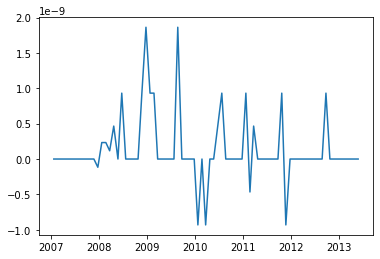

In [6]:
# This graph does a sanity check by confirming that Fixed Realized Losses + ARM Realized Losses = Total Realized Losses
# (accurate to within a fraction of a cent!)
plt.plot(hist_PL_deep_copy.xs('Fixed', level=1)['Realized Losses (Amount)'] + hist_PL_deep_copy.xs('ARM',level=1) \
['Realized Losses (Amount)'] - hist_PL_deep_copy.xs('Total (All Loans)',level=1)['Realized Losses (Amount)'])

In [7]:
# Save the modified dataset in my Data Repository folder
with open('../../data/mbs_data_pickled/hist_PL_with_totals.pkl','wb') as f:
    pickle.dump(hist_PL_deep_copy,f)

In [9]:
# Confirm that the data was saved correctly by loading it up one more time
test = pd.read_pickle('../../data/mbs_data_pickled/hist_PL_with_totals.pkl')
test.xs('2013-05-28',level=0)

,Ending Pool (Count),Ending Pool (Balance),Payoffs (Count),Payoffs (Balance),Insurance Proceeds,Substitution Proceeds,Liquidation Proceeds,Realized Losses (Count),Realized Losses (Amount),Remaining Term,Current WAC [UNSURE ABOUT CALCULATION],Current WAC - Remit [UNSURE ABOUT CALCULATION]
Group,,,,,,,,,,,,
ARM,1342.0,3.028954e+08,1.0,53686.41,0.0,0.0,1058871.64,21.0,2563337.56,281.985649,0.0,0.0
Fixed,714.0,1.311720e+08,0.0,0.00,0.0,0.0,99454.60,5.0,1151482.60,278.770092,0.0,0.0
Group I,646.0,1.232080e+08,1.0,53686.41,0.0,0.0,284096.30,8.0,908268.61,281.367321,0.0,0.0
Group I Loans 228 ARM,445.0,8.923269e+07,1.0,53686.41,0.0,0.0,243300.17,6.0,548723.38,282.000000,NaN,NaN
Group I Loans 327 ARM,18.0,4.057444e+06,0.0,0.00,0.0,0.0,0.00,0.0,0.00,282.000000,NaN,NaN
Group I Loans Fixed 1st Lien,172.0,2.946496e+07,0.0,0.00,0.0,0.0,40796.13,2.0,359545.23,280.000000,NaN,NaN
Group I Loans Fixed 2nd Lien,11.0,4.528856e+05,0.0,0.00,0.0,0.0,0.00,0.0,0.00,240.000000,NaN,NaN
Group II,1410.0,3.108594e+08,0.0,0.00,0.0,0.0,874229.94,18.0,2806551.55,280.873866,0.0,0.0
Group II Loans Subgroup I 228 ARM,302.0,9.159826e+07,0.0,0.00,0.0,0.0,440787.48,7.0,1173281.60,282.000000,NaN,NaN
